In [1]:
import numpy as np

import numpy as np

class DecisionTreeRegressor:
    def __init__(self, min_samples_split=2, max_depth=float('inf'), error_method='variance', cyclic_padding=0, loss_norm=2):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.root = None
        self.error_method = error_method
        self.cyclic_padding = cyclic_padding
        self.loss_norm = loss_norm

    class Node:
        def __init__(self, feature_index=None, threshold=None, left=None, right=None, value=None, data=None, targets=None):
            self.feature_index = feature_index
            self.threshold = threshold
            self.left = left
            self.right = right
            self.value = value
            self.data = data
            self.targets = targets
            if self.left == None and self.right == None:
                self.is_leaf = True
            else:
                self.is_leaf = False

    def fit(self, X, y, depth=0):
        if len(X) < self.min_samples_split or depth >= self.max_depth:
            node = self.Node(value=y.mean(), data=X, targets=y)
            node.is_leaf = True
            return node

        if self.error_method == 'cyclic_minimax':
            best_split = self.cyclic_minimax_split(X, y, depth)
        else:
            best_split = self.find_best_split(X, y)

        best_feature, best_threshold = best_split
        if best_split is None or best_threshold is None:
            node = self.Node(value=y.mean(), data=X, targets=y)
            node.is_leaf = True
            return node
        left_indices = X[:, best_feature] <= best_threshold
        right_indices = ~left_indices
        left_subtree = self.fit(X[left_indices], y[left_indices], depth + 1)
        right_subtree = self.fit(X[right_indices], y[right_indices], depth + 1)
        return self.Node(feature_index=best_feature, threshold=best_threshold, left=left_subtree, right=right_subtree, data=X, targets=y)

    def find_best_split(self, X, y):
        num_features = X.shape[1]
        min_error = float('inf')
        best_feature = None
        best_threshold = None

        for feature_index in range(num_features):
            index, threshold, error = self.evaluate_splits(X, y, feature_index)
            if error < min_error:
                min_error = error
                best_feature = feature_index
                best_threshold = threshold

        return best_feature, best_threshold

    def cyclic_minimax_split(self, X, y, depth):
        num_features = X.shape[1]
        feature_index = (self.cyclic_padding+depth) % num_features
        ###print('cyclic index ',feature_index)
        best_feature, best_threshold, _ = self.evaluate_splits(X, y, feature_index)
        best_feature = feature_index
        return best_feature, best_threshold

    def evaluate_splits(self, X, y, feature_index):
        if self.error_method == 'median_X':
            threshold = np.median(X[:, feature_index])
            left_indices = X[:, feature_index] <= threshold
            right_indices = ~left_indices
            min_error = 0
            best_threshold = threshold
            return feature_index, (best_threshold, min_error)
        elif self.error_method == 'median_y':
            median_y_value = np.median(y)
            index = np.argsort(np.abs(y - median_y_value))[0]
            threshold = X[index, feature_index]
            left_indices = X[:, feature_index] <= threshold
            right_indices = ~left_indices
            min_error = 0
            best_threshold = threshold
            return feature_index, (best_threshold, min_error)
        else:
            thresholds = np.unique(X[:, feature_index])
            min_error = float('inf')
            best_threshold = None
            for threshold in thresholds:
                left_indices = X[:, feature_index] <= threshold
                right_indices = ~left_indices
                error = self.calculate_error(y, left_indices, right_indices) 
                if error < min_error:
                    min_error = error
                    best_threshold = threshold
            return feature_index, best_threshold, min_error
    def calculate_p_norm_error(self, y, indices, p):
        if p == np.inf:
            # Max norm (L-infinity) handling
            return np.max(np.abs(y[indices] - np.mean(y[indices])))
        else:
            # General p-norm
            return np.sum(np.abs(y[indices] - np.mean(y[indices])) ** p)
    def calculate_error(self, y, left_indices, right_indices):
        if sum(left_indices)<=1 or sum(left_indices) is None:
            return np.inf
        if sum(right_indices)<=1 or sum(right_indices) is None:
            return np.inf 
        left_error = right_error = 0
        if self.error_method == 'variance':
            if self.loss_norm == 2:
                # Special case for standard variance (quadratic norm)
                left_error = ((y[left_indices] - y[left_indices].mean()) ** 2).sum()
                right_error = ((y[right_indices] - y[right_indices].mean()) ** 2).sum()
            else:
                # Generic p-norm
                left_error = self.calculate_p_norm_error(y, left_indices, self.loss_norm)
                right_error = self.calculate_p_norm_error(y, right_indices, self.loss_norm)
            return left_error+right_error
        elif self.error_method == 'minimax' or self.error_method == 'cyclic_minimax':
            if self.loss_norm == 2:
                # Special case for standard variance (quadratic norm)
                left_error = ((y[left_indices] - y[left_indices].mean()) ** 2).sum()
                right_error = ((y[right_indices] - y[right_indices].mean()) ** 2).sum()
            else:
                # Generic p-norm
                left_error = self.calculate_p_norm_error(y, left_indices, self.loss_norm)
                right_error = self.calculate_p_norm_error(y, right_indices, self.loss_norm)
            return max(left_error, right_error)
        elif self.error_method == 'weighted_variance':
            left_error = sum(left_indices) * ((y[left_indices] - y[left_indices].mean()) ** 2).sum()
            right_error = sum(right_indices) * ((y[right_indices] - y[right_indices].mean()) ** 2).sum()
            return left_error+right_error
        return left_error + right_error

    def predict(self, X):
        predictions = [self._predict_one(x, self.root) for x in X]
        return predictions

    def _predict_one(self, x, node):
        while not node.is_leaf:
            if x[node.feature_index] <= node.threshold:
                node = node.left
            else:
                node = node.right
        return node.value
    
    def prune(self, node=None):
        if node is None:
            node = self.root

        if node.is_leaf:
            return

        if node.left.is_leaf and node.right.is_leaf:
            original_error = self.node_error(node)
            node.is_leaf = True
            node.value = node.targets.mean()
            pruned_error = self.node_error(node)
            complexity_alpha = 0.1
            original_complexity = original_error + complexity_alpha*self.count_leaves()
            pruned_complexity = pruned_error + complexity_alpha*self.count_leaves()
            if pruned_complexity > original_complexity:
                node.is_leaf = False
                node.value = None
            else:
                node.left = None
                node.right = None

        if not node.is_leaf:
            self.prune(node.left)
            self.prune(node.right)

    def node_error(self, node):
        if node.is_leaf:
            return ((node.targets - node.value) ** 2).mean()
        return ((self.predict(node.data) - node.targets) ** 2).mean()
    
    def print_tree(self, node=None, depth=0):
        if node is None:
            node = self.root

        if node.is_leaf:
            print(f"{'    ' * depth}Leaf: Predict = {node.value:.4f}")
        else:
            print(f"{'    ' * depth}Node: X[{node.feature_index}] <= {node.threshold:.4f}, "
                  f"Error = {self.node_error(node):.4f}")
            self.print_tree(node.left, depth + 1)
            self.print_tree(node.right, depth + 1)

    def count_leaves(self, node=None):
        if node is None:
            node = self.root
        if node.is_leaf:
            return 1
        else:
            return self.count_leaves(node.left) + self.count_leaves(node.right)





Node: X[0] <= -0.0202, Error = 0.0414
    Node: X[0] <= -1.2727, Error = 0.0472
        Node: X[0] <= -1.6768, Error = 0.0567
            Leaf: Predict = 0.4909
            Leaf: Predict = -0.2495
        Node: X[0] <= -0.5051, Error = 0.0413
            Leaf: Predict = -0.9068
            Leaf: Predict = -0.4089
    Node: X[0] <= 1.2323, Error = 0.0357
        Node: X[0] <= 0.3838, Error = 0.0363
            Leaf: Predict = 0.4004
            Leaf: Predict = 0.8967
        Node: X[0] <= 1.6364, Error = 0.0348
            Leaf: Predict = 0.2530
            Leaf: Predict = -0.5051
The number of leaves in the tree: 8
----------------------------------------------------------------------------------------------------


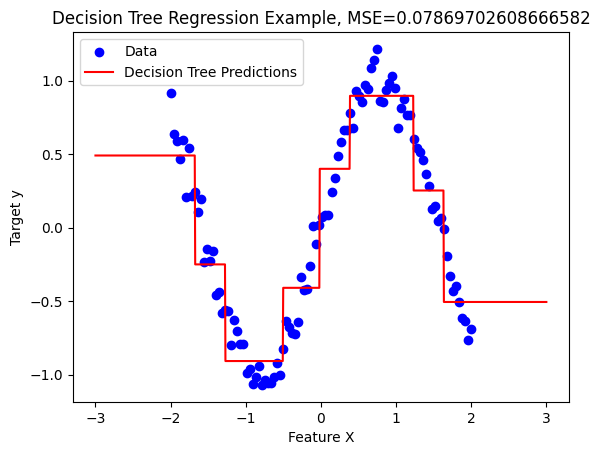

In [2]:
# Create some sample data
np.random.seed(1)
X = np.linspace(-2, 2, 100).reshape(-1, 1)
X_new = np.linspace(-3, 3, 1000).reshape(-1, 1)
shared_noise_var = 0.1

def f_truth(X,noise_var=0.01):
    return  np.sin(X.ravel()*2) + np.random.randn(X.ravel().shape[0]) * noise_var

y = f_truth(X,shared_noise_var)
y_new = f_truth(X_new,shared_noise_var)

# Instantiate and train the decision tree
tree = DecisionTreeRegressor(min_samples_split=2, max_depth=3,error_method='cyclic_minimax',loss_norm=1)
tree.root = tree.fit(X, y)
tree.print_tree()
num_leaves = tree.count_leaves()
print(f"The number of leaves in the tree: {num_leaves}")
print('-'*100)
#tree.prune()
#tree.print_tree()
#num_leaves = tree.count_leaves()
#print(f"The number of leaves in the tree: {num_leaves}")

# Make predictions
predictions = tree.predict(X_new)

# Plotting the results
import matplotlib.pyplot as plt
plt.scatter(X, y, color='blue', label='Data')
plt.plot(X_new, predictions, color='red', label='Decision Tree Predictions')
plt.xlabel('Feature X')
plt.ylabel('Target y')
plt.title('Decision Tree Regression Example, MSE='+str(np.mean((predictions-y_new)**2) ))
plt.legend()
plt.show()

Node: X[0] <= 0.2323, Error = 0.0013
    Node: X[0] <= 0.0303, Error = 0.0035
        Node: X[0] <= 0.0101, Error = 0.0103
            Leaf: Predict = 0.1833
            Leaf: Predict = 0.4012
        Node: X[0] <= 0.1111, Error = 0.0021
            Leaf: Predict = 0.5388
            Leaf: Predict = 0.6650
    Node: X[0] <= 0.5354, Error = 0.0006
        Node: X[0] <= 0.3737, Error = 0.0006
            Leaf: Predict = 0.7495
            Leaf: Predict = 0.8378
        Node: X[0] <= 0.7576, Error = 0.0006
            Leaf: Predict = 0.9098
            Leaf: Predict = 0.9747
The number of leaves in the tree: 8
----------------------------------------------------------------------------------------------------


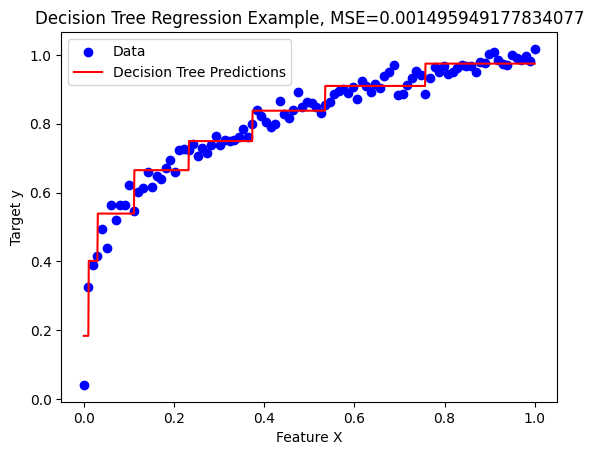

In [3]:
# ZY's x^(-\alpha) sample data
np.random.seed(1)
X = np.linspace(0, 1, 100).reshape(-1, 1)
X_new = np.linspace(0, 1, 1000).reshape(-1, 1)
shared_noise_var = 0.025

def f_truth(X,noise_var=0.01):
    return  np.power(X.ravel(),0.234) + np.random.randn(X.ravel().shape[0]) * noise_var

y = f_truth(X,shared_noise_var)
y_new = f_truth(X_new,shared_noise_var)

# Instantiate and train the decision tree
tree = DecisionTreeRegressor(min_samples_split=2, max_depth=3,error_method='cyclic_minimax')
tree.root = tree.fit(X, y)
tree.print_tree()
num_leaves = tree.count_leaves()
print(f"The number of leaves in the tree: {num_leaves}")
print('-'*100)
#tree.prune()
#tree.print_tree()
#num_leaves = tree.count_leaves()
#print(f"The number of leaves in the tree: {num_leaves}")

# Make predictions
predictions = tree.predict(X_new)

# Plotting the results
import matplotlib.pyplot as plt
plt.scatter(X, y, color='blue', label='Data')
plt.plot(X_new, predictions, color='red', label='Decision Tree Predictions')
plt.xlabel('Feature X')
plt.ylabel('Target y')
plt.title('Decision Tree Regression Example, MSE='+str(np.mean((predictions-y_new)**2) ))
plt.legend()
plt.show()

In [4]:
import numpy as np

class RandomForestRegressor:
    def __init__(self, n_estimators=2, min_samples_split=2, max_depth=float('inf'), error_method='variance', loss_norm=2, use_weights=False):
        self.n_estimators = n_estimators
        self.use_weights = use_weights
        self.weights = None

        if isinstance(error_method, list):
            assert len(error_method) == n_estimators
            if isinstance(loss_norm, list):
                self.trees = [
                    DecisionTreeRegressor(min_samples_split=min_samples_split, max_depth=max_depth, error_method=error_method[i], cyclic_padding=i, loss_norm=loss_norm[i])
                    for i in range(n_estimators)
                ]
            else:
                self.trees = [
                    DecisionTreeRegressor(min_samples_split=min_samples_split, max_depth=max_depth, error_method=error_method[i], cyclic_padding=i, loss_norm=loss_norm)
                    for i in range(n_estimators)
                ]
        else:
            self.trees = [
                DecisionTreeRegressor(min_samples_split=min_samples_split, max_depth=max_depth, error_method=error_method, cyclic_padding=i, loss_norm=loss_norm)
                for i in range(n_estimators)
            ]

    def fit(self, X, y):
        self.weights = np.ones(self.n_estimators)
        for i, tree in enumerate(self.trees):
            indices = np.random.choice(len(X), len(X), replace=True)
            X_sample, y_sample = X[indices], y[indices]
            tree.root = tree.fit(X_sample, y_sample)
            
            if self.use_weights:
                # Calculate RMSE for this tree
                predictions = tree.predict(X_sample)
                mse = np.mean((y_sample - predictions) ** 2)
                rmse = np.sqrt(mse)
                self.weights[i] = 1 / rmse if rmse > 0 else 1

        if self.use_weights:
            # Normalize weights
            self.weights /= np.sum(self.weights)

    def predict(self, X):
        predictions = np.zeros((self.n_estimators, len(X)))
        for i, tree in enumerate(self.trees):
            if tree.root is not None:  # Ensure the tree is fitted
                predictions[i] = tree.predict(X)
        
        if self.use_weights:
            return np.average(predictions, axis=0, weights=self.weights)
        else:
            return np.mean(predictions, axis=0)

    def print_trees(self):
        for i, tree in enumerate(self.trees):
            print(f"Tree {i}:")
            tree.print_tree()

In [5]:
rf = RandomForestRegressor(n_estimators=5, use_weights=False)
rf.fit(X, y)
predictions = rf.predict(X_new)
print('unweighted (usual) RF testing MSE:',np.mean((predictions-y_new)**2))

rf = RandomForestRegressor(n_estimators=5, use_weights=True)
rf.fit(X, y)
predictions = rf.predict(X_new)
print('weighted RF testing MSE:',np.mean((predictions-y_new)**2))

unweighted (usual) RF testing MSE: 0.0009287430093562768
weighted RF testing MSE: 0.0009805444093202956


# L2 norm

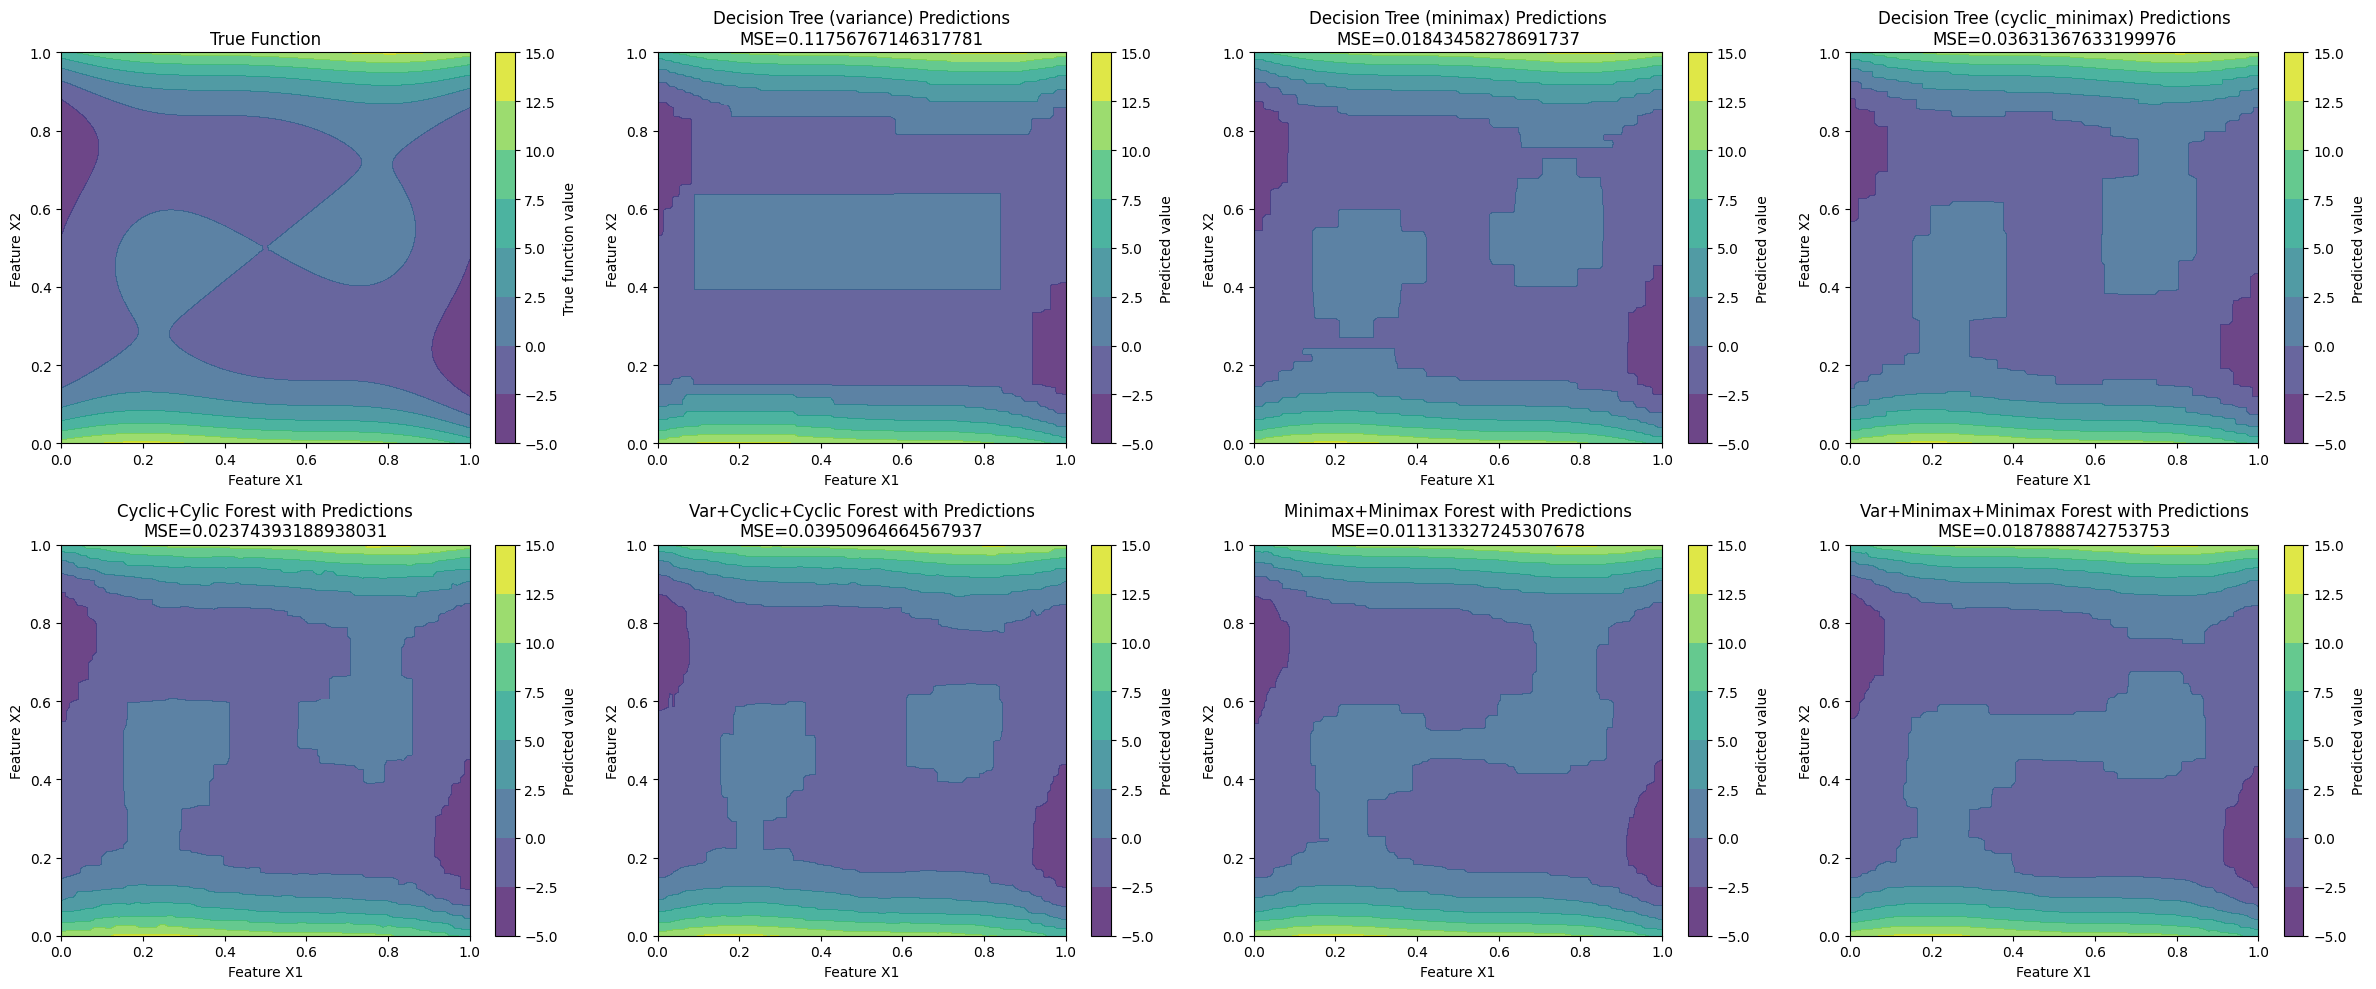

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Setting seed for reproducibility
np.random.seed(1)

# Generating a 2D grid of features
x1 = np.linspace(0, 1, 100)
x2 = np.linspace(0, 1, 100)
X1, X2 = np.meshgrid(x1, x2)
X = np.c_[X1.ravel(), X2.ravel()]  # Create a 2-column matrix of features

# Define a function that depends on X1 and X2
def f_truth(X, noise_var=0.1):
    x1 = (X[:,0] -.5)*3
    x2 = (X[:,1] -.5)*3
    return (2-2.1*x1**2+x1**4/3)*x1**2+x1*x2+(-4+4*x2**2)*x2**2#https://www.sfu.ca/~ssurjano/camel6.html
    #return np.power(X[:, 0], 0.234) + np.sin(2 * np.pi * X[:, 1]) + np.random.randn(X.shape[0]) * noise_var

y = f_truth(X)

# Prepare the mesh grid for predictions and visualization
X_new = np.c_[X1.ravel(), X2.ravel()]
y_new = f_truth(X_new)  # Slightly less noise for cleaner function visualization

shared_max_depth=10
# Assuming the DecisionTreeRegressor and RandomForestRegressor classes have already been imported and are available
# Variance-based Decision Tree
tree_variance = DecisionTreeRegressor(min_samples_split=4, max_depth=shared_max_depth, error_method='variance')
tree_variance.root = tree_variance.fit(X, y)
predictions_variance = tree_variance.predict(X_new)
predictions_variance = np.asarray(predictions_variance).reshape(X1.shape)  # Reshape to 2D grid

# Minimax Decision Tree
tree_minimax = DecisionTreeRegressor(min_samples_split=4, max_depth=shared_max_depth, error_method='minimax')
tree_minimax.root = tree_minimax.fit(X, y)
predictions_minimax = tree_minimax.predict(X_new)
predictions_minimax = np.asarray(predictions_minimax).reshape(X1.shape)  # Reshape to 2D grid

# Cyclic minimax Decision Tree
tree_cyclic_minimax = DecisionTreeRegressor(min_samples_split=4, max_depth=shared_max_depth, error_method='cyclic_minimax')
tree_cyclic_minimax.root = tree_cyclic_minimax.fit(X, y)
predictions_cyclic_minimax = tree_cyclic_minimax.predict(X_new)
predictions_cyclic_minimax = np.asarray(predictions_cyclic_minimax).reshape(X1.shape)  # Reshape to 2D grid

# Random Forest Regressor
forest = RandomForestRegressor(n_estimators=2, min_samples_split=4, max_depth=shared_max_depth, error_method=['cyclic_minimax','cyclic_minimax'])
forest.fit(X, y)
predictions_forest1 = forest.predict(X_new)
predictions_forest1 = np.asarray(predictions_forest1).reshape(X1.shape)  # Reshape to 2D grid

forest = RandomForestRegressor(n_estimators=3, min_samples_split=4, max_depth=shared_max_depth, error_method=['variance','cyclic_minimax','cyclic_minimax'])
forest.fit(X, y)
predictions_forest2 = forest.predict(X_new)
predictions_forest2 = np.asarray(predictions_forest2).reshape(X1.shape)  # Reshape to 2D grid

forest = RandomForestRegressor(n_estimators=2, min_samples_split=4, max_depth=shared_max_depth, error_method=['minimax','minimax'])
forest.fit(X, y)
predictions_forest3 = forest.predict(X_new)
predictions_forest3 = np.asarray(predictions_forest3).reshape(X1.shape)  # Reshape to 2D grid

forest = RandomForestRegressor(n_estimators=3, min_samples_split=4, max_depth=shared_max_depth, error_method=['variance','minimax','minimax'])
forest.fit(X, y)
predictions_forest4 = forest.predict(X_new)
predictions_forest4 = np.asarray(predictions_forest4).reshape(X1.shape)  # Reshape to 2D grid



# Plotting the original data and the decision tree approximation
plt.figure(figsize=(24, 10))

# Original function plot
plt.subplot(2, 4, 1)
plt.contourf(X1, X2, y_new.reshape(X1.shape), cmap='viridis', alpha=0.8)
plt.colorbar(label='True function value')
plt.title('True Function')
plt.xlabel('Feature X1')
plt.ylabel('Feature X2')

# Decision tree (variance) predictions plot
plt.subplot(2, 4, 2)
plt.contourf(X1, X2, predictions_variance, cmap='viridis', alpha=0.8)
plt.colorbar(label='Predicted value')
plt.title('Decision Tree (variance) Predictions\nMSE='+str(np.mean((predictions_variance.ravel()-y_new)**2)))
plt.xlabel('Feature X1')
plt.ylabel('Feature X2')

# Decision tree (minimax) predictions plot
plt.subplot(2, 4, 3)
plt.contourf(X1, X2, predictions_minimax, cmap='viridis', alpha=0.8)
plt.colorbar(label='Predicted value')
plt.title('Decision Tree (minimax) Predictions\nMSE='+str(np.mean((predictions_minimax.ravel()-y_new)**2)))
plt.xlabel('Feature X1')
plt.ylabel('Feature X2')

# Decision tree (cyclic_minimax) predictions plot
plt.subplot(2, 4, 4)
plt.contourf(X1, X2, predictions_cyclic_minimax, cmap='viridis', alpha=0.8)
plt.colorbar(label='Predicted value')
plt.title('Decision Tree (cyclic_minimax) Predictions\nMSE='+str(np.mean((predictions_cyclic_minimax.ravel()-y_new)**2)))
plt.xlabel('Feature X1')
plt.ylabel('Feature X2')

# Random Forest predictions plot
plt.subplot(2, 4, 5)
plt.contourf(X1, X2, predictions_forest1, cmap='viridis', alpha=0.8)
plt.colorbar(label='Predicted value')
plt.title('Cyclic+Cylic Forest with Predictions\nMSE='+str(np.mean((predictions_forest1.ravel()-y_new)**2)))
plt.xlabel('Feature X1')
plt.ylabel('Feature X2')

plt.subplot(2, 4, 6)
plt.contourf(X1, X2, predictions_forest2, cmap='viridis', alpha=0.8)
plt.colorbar(label='Predicted value')
plt.title('Var+Cyclic+Cyclic Forest with Predictions\nMSE='+str(np.mean((predictions_forest2.ravel()-y_new)**2)))
plt.xlabel('Feature X1')
plt.ylabel('Feature X2')

plt.subplot(2, 4, 7)
plt.contourf(X1, X2, predictions_forest3, cmap='viridis', alpha=0.8)
plt.colorbar(label='Predicted value')
plt.title('Minimax+Minimax Forest with Predictions\nMSE='+str(np.mean((predictions_forest3.ravel()-y_new)**2)))
plt.xlabel('Feature X1')
plt.ylabel('Feature X2')

plt.subplot(2, 4, 8)
plt.contourf(X1, X2, predictions_forest4, cmap='viridis', alpha=0.8)
plt.colorbar(label='Predicted value')
plt.title('Var+Minimax+Minimax Forest with Predictions\nMSE='+str(np.mean((predictions_forest4.ravel()-y_new)**2)))
plt.xlabel('Feature X1')
plt.ylabel('Feature X2')

plt.tight_layout()
plt.show()


# L1 norm

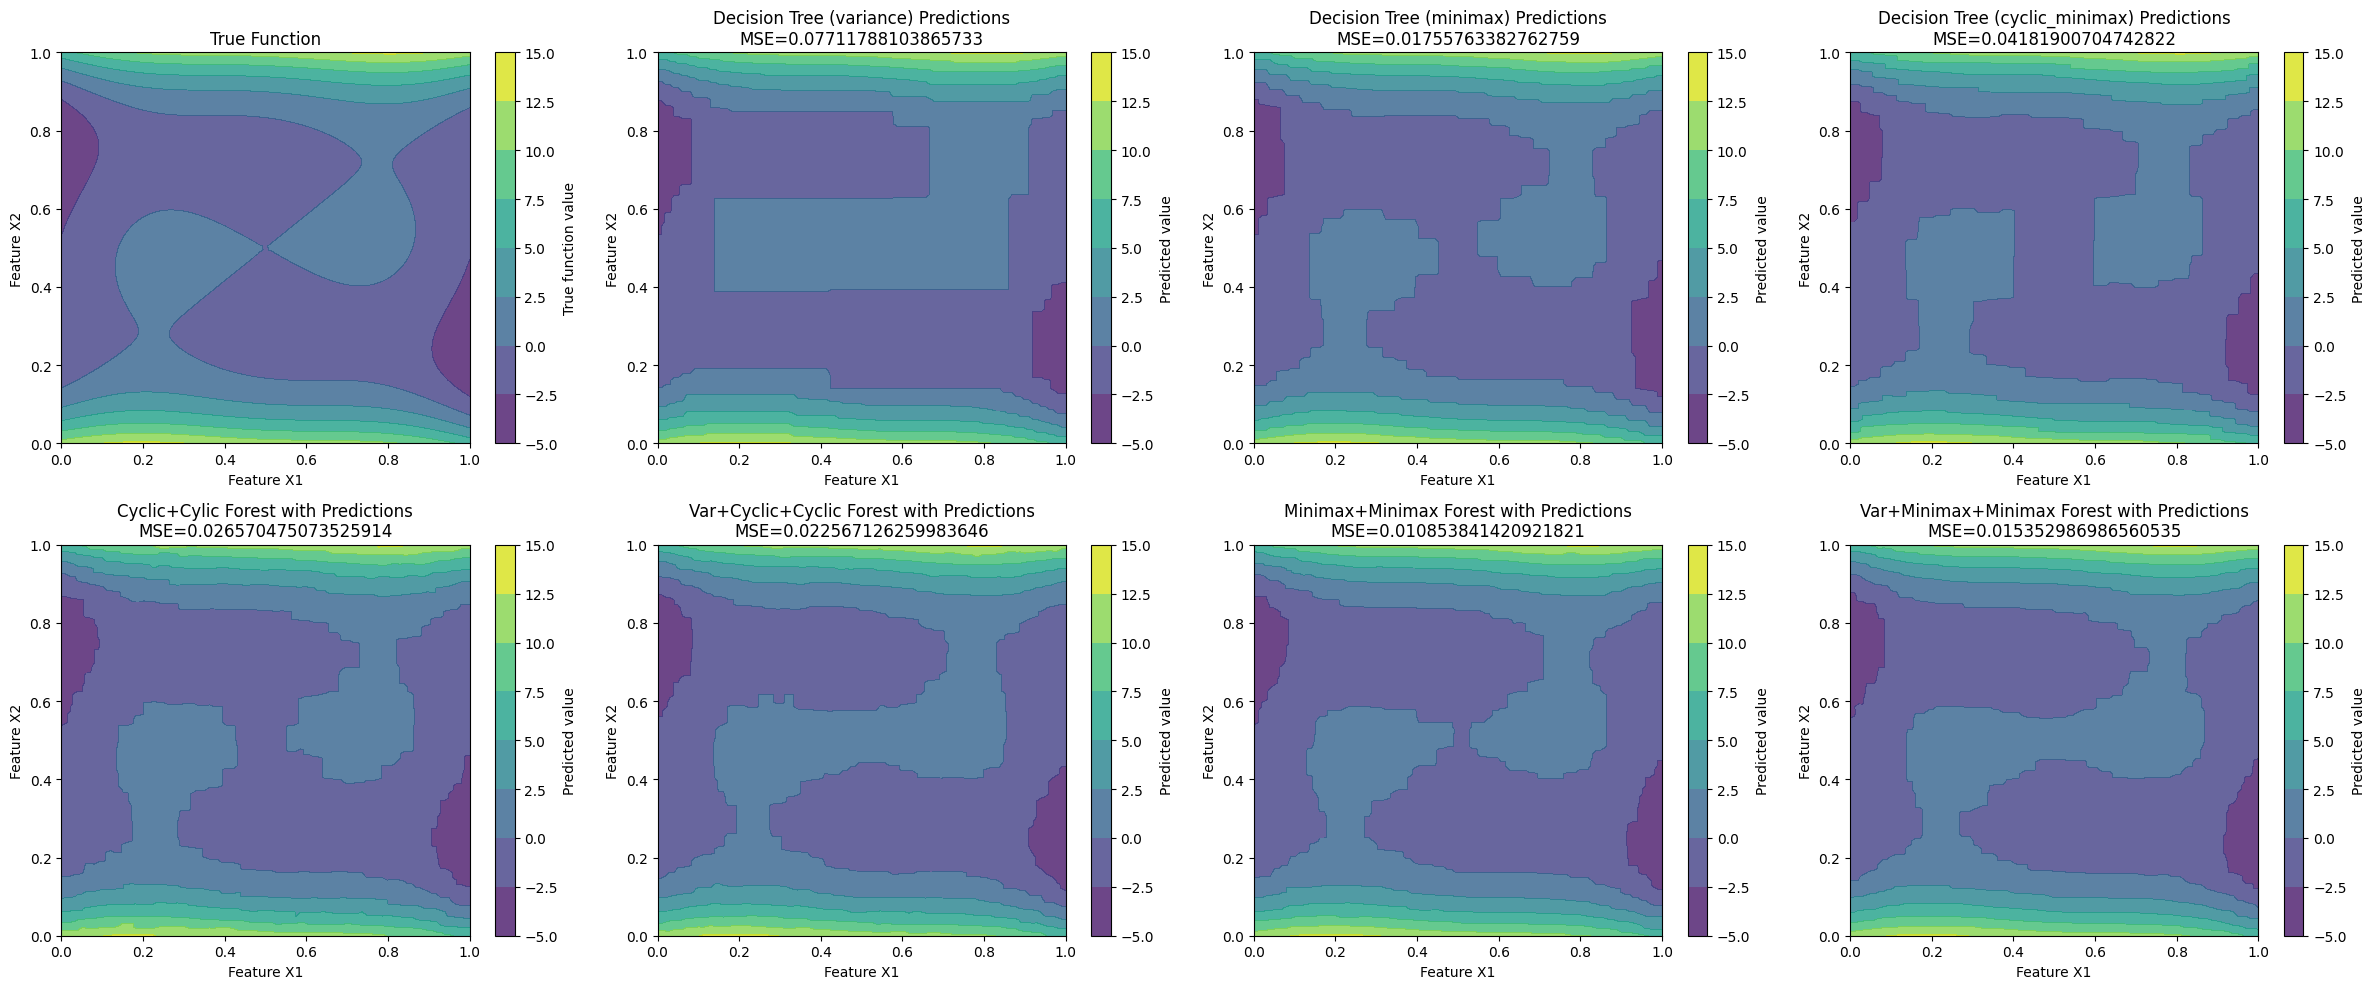

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Setting seed for reproducibility
np.random.seed(1)

# Generating a 2D grid of features
x1 = np.linspace(0, 1, 100)
x2 = np.linspace(0, 1, 100)
X1, X2 = np.meshgrid(x1, x2)
X = np.c_[X1.ravel(), X2.ravel()]  # Create a 2-column matrix of features

# Define a function that depends on X1 and X2
def f_truth(X, noise_var=0.1):
    x1 = (X[:,0] -.5)*3
    x2 = (X[:,1] -.5)*3
    return (2-2.1*x1**2+x1**4/3)*x1**2+x1*x2+(-4+4*x2**2)*x2**2#https://www.sfu.ca/~ssurjano/camel6.html
    #return np.power(X[:, 0], 0.234) + np.sin(2 * np.pi * X[:, 1]) + np.random.randn(X.shape[0]) * noise_var

y = f_truth(X)

# Prepare the mesh grid for predictions and visualization
X_new = np.c_[X1.ravel(), X2.ravel()]
y_new = f_truth(X_new)  # Slightly less noise for cleaner function visualization

shared_max_depth=10
# Assuming the DecisionTreeRegressor and RandomForestRegressor classes have already been imported and are available
# Variance-based Decision Tree
tree_variance = DecisionTreeRegressor(min_samples_split=4, max_depth=shared_max_depth, error_method='variance', loss_norm=1)
tree_variance.root = tree_variance.fit(X, y)
predictions_variance = tree_variance.predict(X_new)
predictions_variance = np.asarray(predictions_variance).reshape(X1.shape)  # Reshape to 2D grid

# Minimax Decision Tree
tree_minimax = DecisionTreeRegressor(min_samples_split=4, max_depth=shared_max_depth, error_method='minimax', loss_norm=1)
tree_minimax.root = tree_minimax.fit(X, y)
predictions_minimax = tree_minimax.predict(X_new)
predictions_minimax = np.asarray(predictions_minimax).reshape(X1.shape)  # Reshape to 2D grid

# Cyclic minimax Decision Tree
tree_cyclic_minimax = DecisionTreeRegressor(min_samples_split=4, max_depth=shared_max_depth, error_method='cyclic_minimax', loss_norm=1)
tree_cyclic_minimax.root = tree_cyclic_minimax.fit(X, y)
predictions_cyclic_minimax = tree_cyclic_minimax.predict(X_new)
predictions_cyclic_minimax = np.asarray(predictions_cyclic_minimax).reshape(X1.shape)  # Reshape to 2D grid

# Random Forest Regressor
forest = RandomForestRegressor(n_estimators=2, min_samples_split=4, max_depth=shared_max_depth, error_method=['cyclic_minimax','cyclic_minimax'], loss_norm=1)
forest.fit(X, y)
predictions_forest1 = forest.predict(X_new)
predictions_forest1 = np.asarray(predictions_forest1).reshape(X1.shape)  # Reshape to 2D grid

forest = RandomForestRegressor(n_estimators=3, min_samples_split=4, max_depth=shared_max_depth, error_method=['variance','cyclic_minimax','cyclic_minimax'], loss_norm=1)
forest.fit(X, y)
predictions_forest2 = forest.predict(X_new)
predictions_forest2 = np.asarray(predictions_forest2).reshape(X1.shape)  # Reshape to 2D grid

forest = RandomForestRegressor(n_estimators=2, min_samples_split=4, max_depth=shared_max_depth, error_method=['minimax','minimax'], loss_norm=1)
forest.fit(X, y)
predictions_forest3 = forest.predict(X_new)
predictions_forest3 = np.asarray(predictions_forest3).reshape(X1.shape)  # Reshape to 2D grid

forest = RandomForestRegressor(n_estimators=3, min_samples_split=4, max_depth=shared_max_depth, error_method=['variance','minimax','minimax'], loss_norm=1)
forest.fit(X, y)
predictions_forest4 = forest.predict(X_new)
predictions_forest4 = np.asarray(predictions_forest4).reshape(X1.shape)  # Reshape to 2D grid



# Plotting the original data and the decision tree approximation
plt.figure(figsize=(24, 10))

# Original function plot
plt.subplot(2, 4, 1)
plt.contourf(X1, X2, y_new.reshape(X1.shape), cmap='viridis', alpha=0.8)
plt.colorbar(label='True function value')
plt.title('True Function')
plt.xlabel('Feature X1')
plt.ylabel('Feature X2')

# Decision tree (variance) predictions plot
plt.subplot(2, 4, 2)
plt.contourf(X1, X2, predictions_variance, cmap='viridis', alpha=0.8)
plt.colorbar(label='Predicted value')
plt.title('Decision Tree (variance) Predictions\nMSE='+str(np.mean((predictions_variance.ravel()-y_new)**2)))
plt.xlabel('Feature X1')
plt.ylabel('Feature X2')

# Decision tree (minimax) predictions plot
plt.subplot(2, 4, 3)
plt.contourf(X1, X2, predictions_minimax, cmap='viridis', alpha=0.8)
plt.colorbar(label='Predicted value')
plt.title('Decision Tree (minimax) Predictions\nMSE='+str(np.mean((predictions_minimax.ravel()-y_new)**2)))
plt.xlabel('Feature X1')
plt.ylabel('Feature X2')

# Decision tree (cyclic_minimax) predictions plot
plt.subplot(2, 4, 4)
plt.contourf(X1, X2, predictions_cyclic_minimax, cmap='viridis', alpha=0.8)
plt.colorbar(label='Predicted value')
plt.title('Decision Tree (cyclic_minimax) Predictions\nMSE='+str(np.mean((predictions_cyclic_minimax.ravel()-y_new)**2)))
plt.xlabel('Feature X1')
plt.ylabel('Feature X2')

# Random Forest predictions plot
plt.subplot(2, 4, 5)
plt.contourf(X1, X2, predictions_forest1, cmap='viridis', alpha=0.8)
plt.colorbar(label='Predicted value')
plt.title('Cyclic+Cylic Forest with Predictions\nMSE='+str(np.mean((predictions_forest1.ravel()-y_new)**2)))
plt.xlabel('Feature X1')
plt.ylabel('Feature X2')

plt.subplot(2, 4, 6)
plt.contourf(X1, X2, predictions_forest2, cmap='viridis', alpha=0.8)
plt.colorbar(label='Predicted value')
plt.title('Var+Cyclic+Cyclic Forest with Predictions\nMSE='+str(np.mean((predictions_forest2.ravel()-y_new)**2)))
plt.xlabel('Feature X1')
plt.ylabel('Feature X2')

plt.subplot(2, 4, 7)
plt.contourf(X1, X2, predictions_forest3, cmap='viridis', alpha=0.8)
plt.colorbar(label='Predicted value')
plt.title('Minimax+Minimax Forest with Predictions\nMSE='+str(np.mean((predictions_forest3.ravel()-y_new)**2)))
plt.xlabel('Feature X1')
plt.ylabel('Feature X2')

plt.subplot(2, 4, 8)
plt.contourf(X1, X2, predictions_forest4, cmap='viridis', alpha=0.8)
plt.colorbar(label='Predicted value')
plt.title('Var+Minimax+Minimax Forest with Predictions\nMSE='+str(np.mean((predictions_forest4.ravel()-y_new)**2)))
plt.xlabel('Feature X1')
plt.ylabel('Feature X2')

plt.tight_layout()
plt.show()


# L3 norm

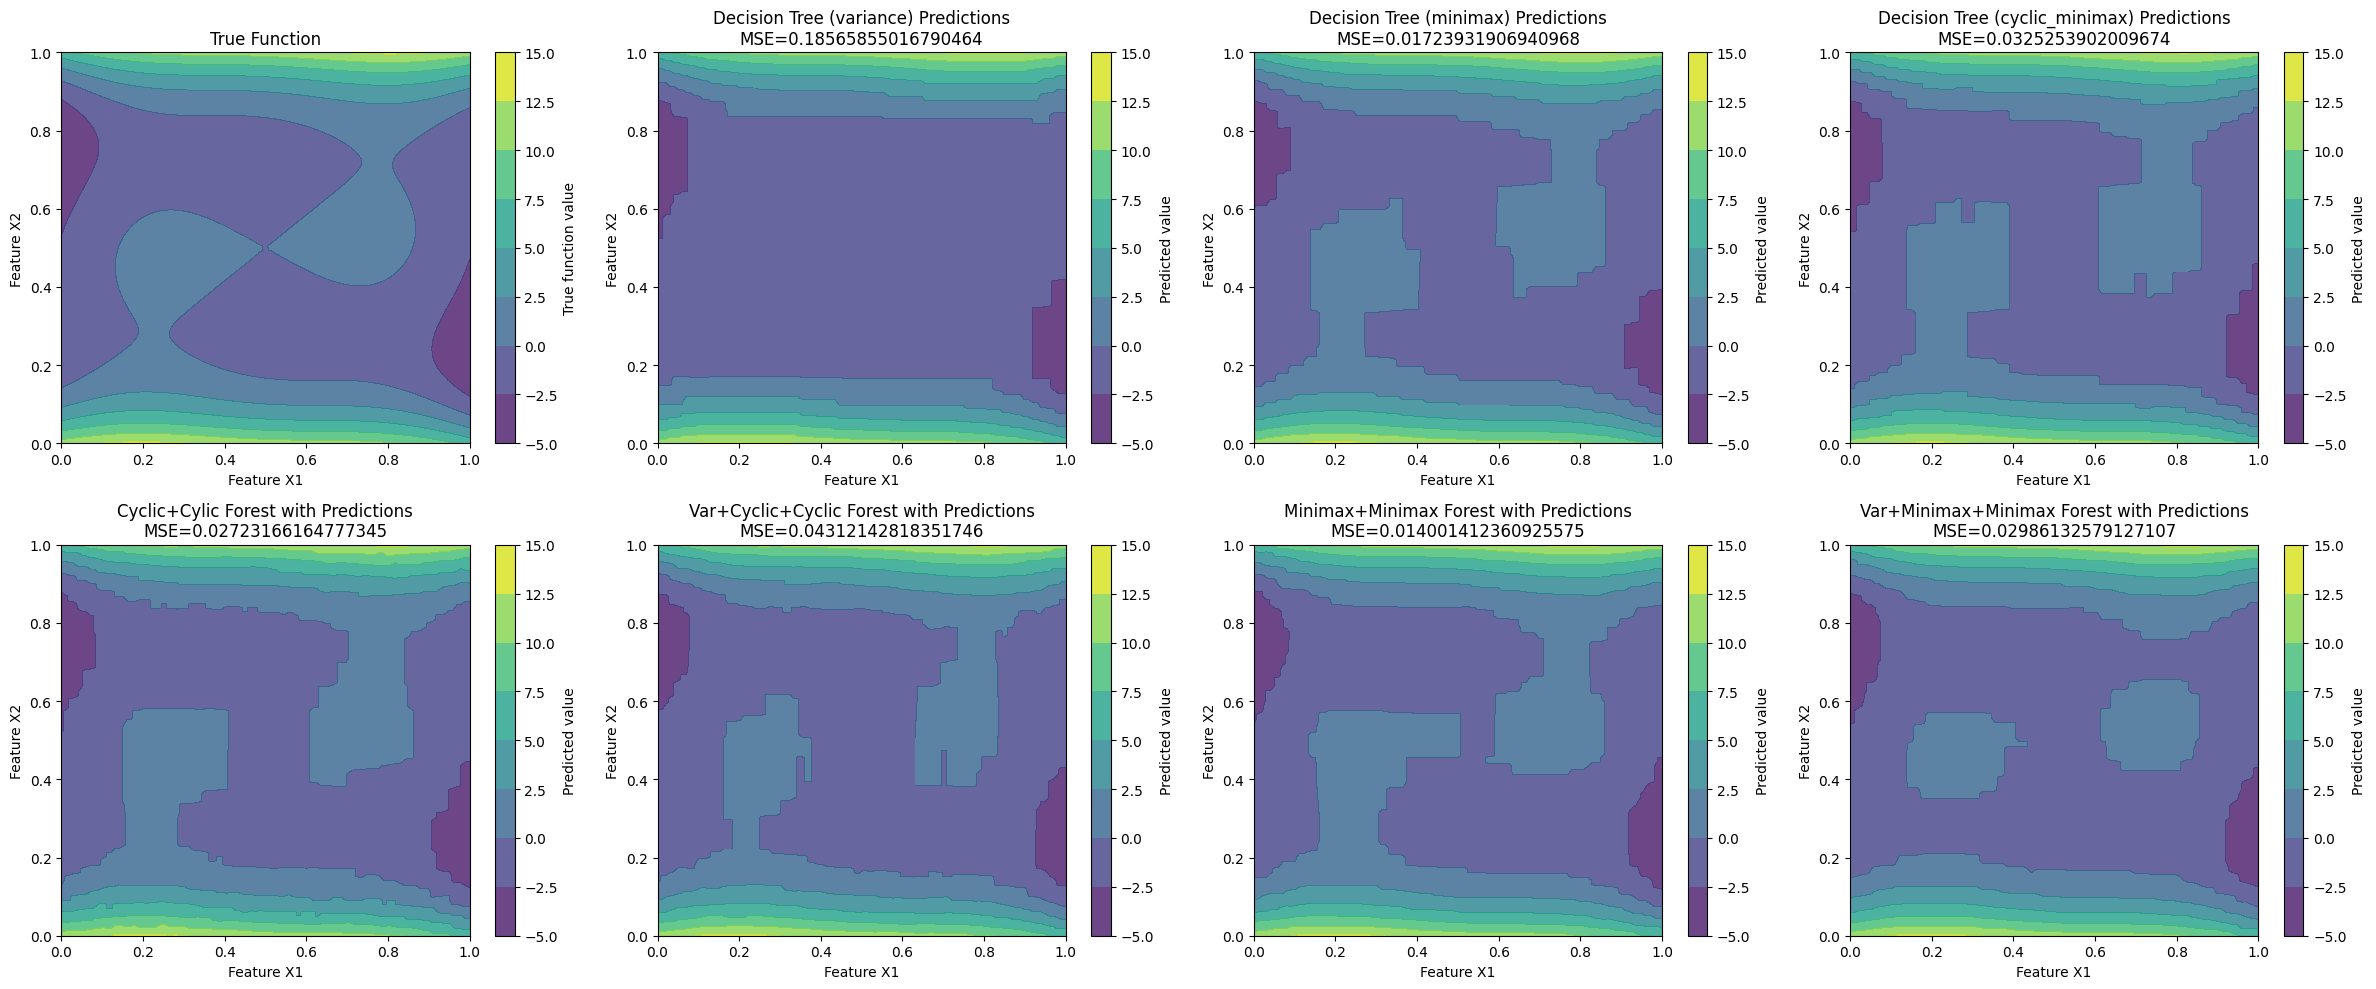

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Setting seed for reproducibility
np.random.seed(1)

# Generating a 2D grid of features
x1 = np.linspace(0, 1, 100)
x2 = np.linspace(0, 1, 100)
X1, X2 = np.meshgrid(x1, x2)
X = np.c_[X1.ravel(), X2.ravel()]  # Create a 2-column matrix of features

# Define a function that depends on X1 and X2
def f_truth(X, noise_var=0.1):
    x1 = (X[:,0] -.5)*3
    x2 = (X[:,1] -.5)*3
    return (2-2.1*x1**2+x1**4/3)*x1**2+x1*x2+(-4+4*x2**2)*x2**2#https://www.sfu.ca/~ssurjano/camel6.html
    #return np.power(X[:, 0], 0.234) + np.sin(2 * np.pi * X[:, 1]) + np.random.randn(X.shape[0]) * noise_var

y = f_truth(X)

# Prepare the mesh grid for predictions and visualization
X_new = np.c_[X1.ravel(), X2.ravel()]
y_new = f_truth(X_new)  # Slightly less noise for cleaner function visualization

shared_max_depth=10
# Assuming the DecisionTreeRegressor and RandomForestRegressor classes have already been imported and are available
# Variance-based Decision Tree
tree_variance = DecisionTreeRegressor(min_samples_split=4, max_depth=shared_max_depth, error_method='variance', loss_norm=3)
tree_variance.root = tree_variance.fit(X, y)
predictions_variance = tree_variance.predict(X_new)
predictions_variance = np.asarray(predictions_variance).reshape(X1.shape)  # Reshape to 2D grid

# Minimax Decision Tree
tree_minimax = DecisionTreeRegressor(min_samples_split=4, max_depth=shared_max_depth, error_method='minimax', loss_norm=3)
tree_minimax.root = tree_minimax.fit(X, y)
predictions_minimax = tree_minimax.predict(X_new)
predictions_minimax = np.asarray(predictions_minimax).reshape(X1.shape)  # Reshape to 2D grid

# Cyclic minimax Decision Tree
tree_cyclic_minimax = DecisionTreeRegressor(min_samples_split=4, max_depth=shared_max_depth, error_method='cyclic_minimax', loss_norm=3)
tree_cyclic_minimax.root = tree_cyclic_minimax.fit(X, y)
predictions_cyclic_minimax = tree_cyclic_minimax.predict(X_new)
predictions_cyclic_minimax = np.asarray(predictions_cyclic_minimax).reshape(X1.shape)  # Reshape to 2D grid

# Random Forest Regressor
forest = RandomForestRegressor(n_estimators=2, min_samples_split=4, max_depth=shared_max_depth, error_method=['cyclic_minimax','cyclic_minimax'], loss_norm=3)
forest.fit(X, y)
predictions_forest1 = forest.predict(X_new)
predictions_forest1 = np.asarray(predictions_forest1).reshape(X1.shape)  # Reshape to 2D grid

forest = RandomForestRegressor(n_estimators=3, min_samples_split=4, max_depth=shared_max_depth, error_method=['variance','cyclic_minimax','cyclic_minimax'], loss_norm=3)
forest.fit(X, y)
predictions_forest2 = forest.predict(X_new)
predictions_forest2 = np.asarray(predictions_forest2).reshape(X1.shape)  # Reshape to 2D grid

forest = RandomForestRegressor(n_estimators=2, min_samples_split=4, max_depth=shared_max_depth, error_method=['minimax','minimax'], loss_norm=3)
forest.fit(X, y)
predictions_forest3 = forest.predict(X_new)
predictions_forest3 = np.asarray(predictions_forest3).reshape(X1.shape)  # Reshape to 2D grid

forest = RandomForestRegressor(n_estimators=3, min_samples_split=4, max_depth=shared_max_depth, error_method=['variance','minimax','minimax'], loss_norm=3)
forest.fit(X, y)
predictions_forest4 = forest.predict(X_new)
predictions_forest4 = np.asarray(predictions_forest4).reshape(X1.shape)  # Reshape to 2D grid



# Plotting the original data and the decision tree approximation
plt.figure(figsize=(24, 10))

# Original function plot
plt.subplot(2, 4, 1)
plt.contourf(X1, X2, y_new.reshape(X1.shape), cmap='viridis', alpha=0.8)
plt.colorbar(label='True function value')
plt.title('True Function')
plt.xlabel('Feature X1')
plt.ylabel('Feature X2')

# Decision tree (variance) predictions plot
plt.subplot(2, 4, 2)
plt.contourf(X1, X2, predictions_variance, cmap='viridis', alpha=0.8)
plt.colorbar(label='Predicted value')
plt.title('Decision Tree (variance) Predictions\nMSE='+str(np.mean((predictions_variance.ravel()-y_new)**2)))
plt.xlabel('Feature X1')
plt.ylabel('Feature X2')

# Decision tree (minimax) predictions plot
plt.subplot(2, 4, 3)
plt.contourf(X1, X2, predictions_minimax, cmap='viridis', alpha=0.8)
plt.colorbar(label='Predicted value')
plt.title('Decision Tree (minimax) Predictions\nMSE='+str(np.mean((predictions_minimax.ravel()-y_new)**2)))
plt.xlabel('Feature X1')
plt.ylabel('Feature X2')

# Decision tree (cyclic_minimax) predictions plot
plt.subplot(2, 4, 4)
plt.contourf(X1, X2, predictions_cyclic_minimax, cmap='viridis', alpha=0.8)
plt.colorbar(label='Predicted value')
plt.title('Decision Tree (cyclic_minimax) Predictions\nMSE='+str(np.mean((predictions_cyclic_minimax.ravel()-y_new)**2)))
plt.xlabel('Feature X1')
plt.ylabel('Feature X2')

# Random Forest predictions plot
plt.subplot(2, 4, 5)
plt.contourf(X1, X2, predictions_forest1, cmap='viridis', alpha=0.8)
plt.colorbar(label='Predicted value')
plt.title('Cyclic+Cylic Forest with Predictions\nMSE='+str(np.mean((predictions_forest1.ravel()-y_new)**2)))
plt.xlabel('Feature X1')
plt.ylabel('Feature X2')

plt.subplot(2, 4, 6)
plt.contourf(X1, X2, predictions_forest2, cmap='viridis', alpha=0.8)
plt.colorbar(label='Predicted value')
plt.title('Var+Cyclic+Cyclic Forest with Predictions\nMSE='+str(np.mean((predictions_forest2.ravel()-y_new)**2)))
plt.xlabel('Feature X1')
plt.ylabel('Feature X2')

plt.subplot(2, 4, 7)
plt.contourf(X1, X2, predictions_forest3, cmap='viridis', alpha=0.8)
plt.colorbar(label='Predicted value')
plt.title('Minimax+Minimax Forest with Predictions\nMSE='+str(np.mean((predictions_forest3.ravel()-y_new)**2)))
plt.xlabel('Feature X1')
plt.ylabel('Feature X2')

plt.subplot(2, 4, 8)
plt.contourf(X1, X2, predictions_forest4, cmap='viridis', alpha=0.8)
plt.colorbar(label='Predicted value')
plt.title('Var+Minimax+Minimax Forest with Predictions\nMSE='+str(np.mean((predictions_forest4.ravel()-y_new)**2)))
plt.xlabel('Feature X1')
plt.ylabel('Feature X2')

plt.tight_layout()
plt.show()


# L1+L2+L3 norm

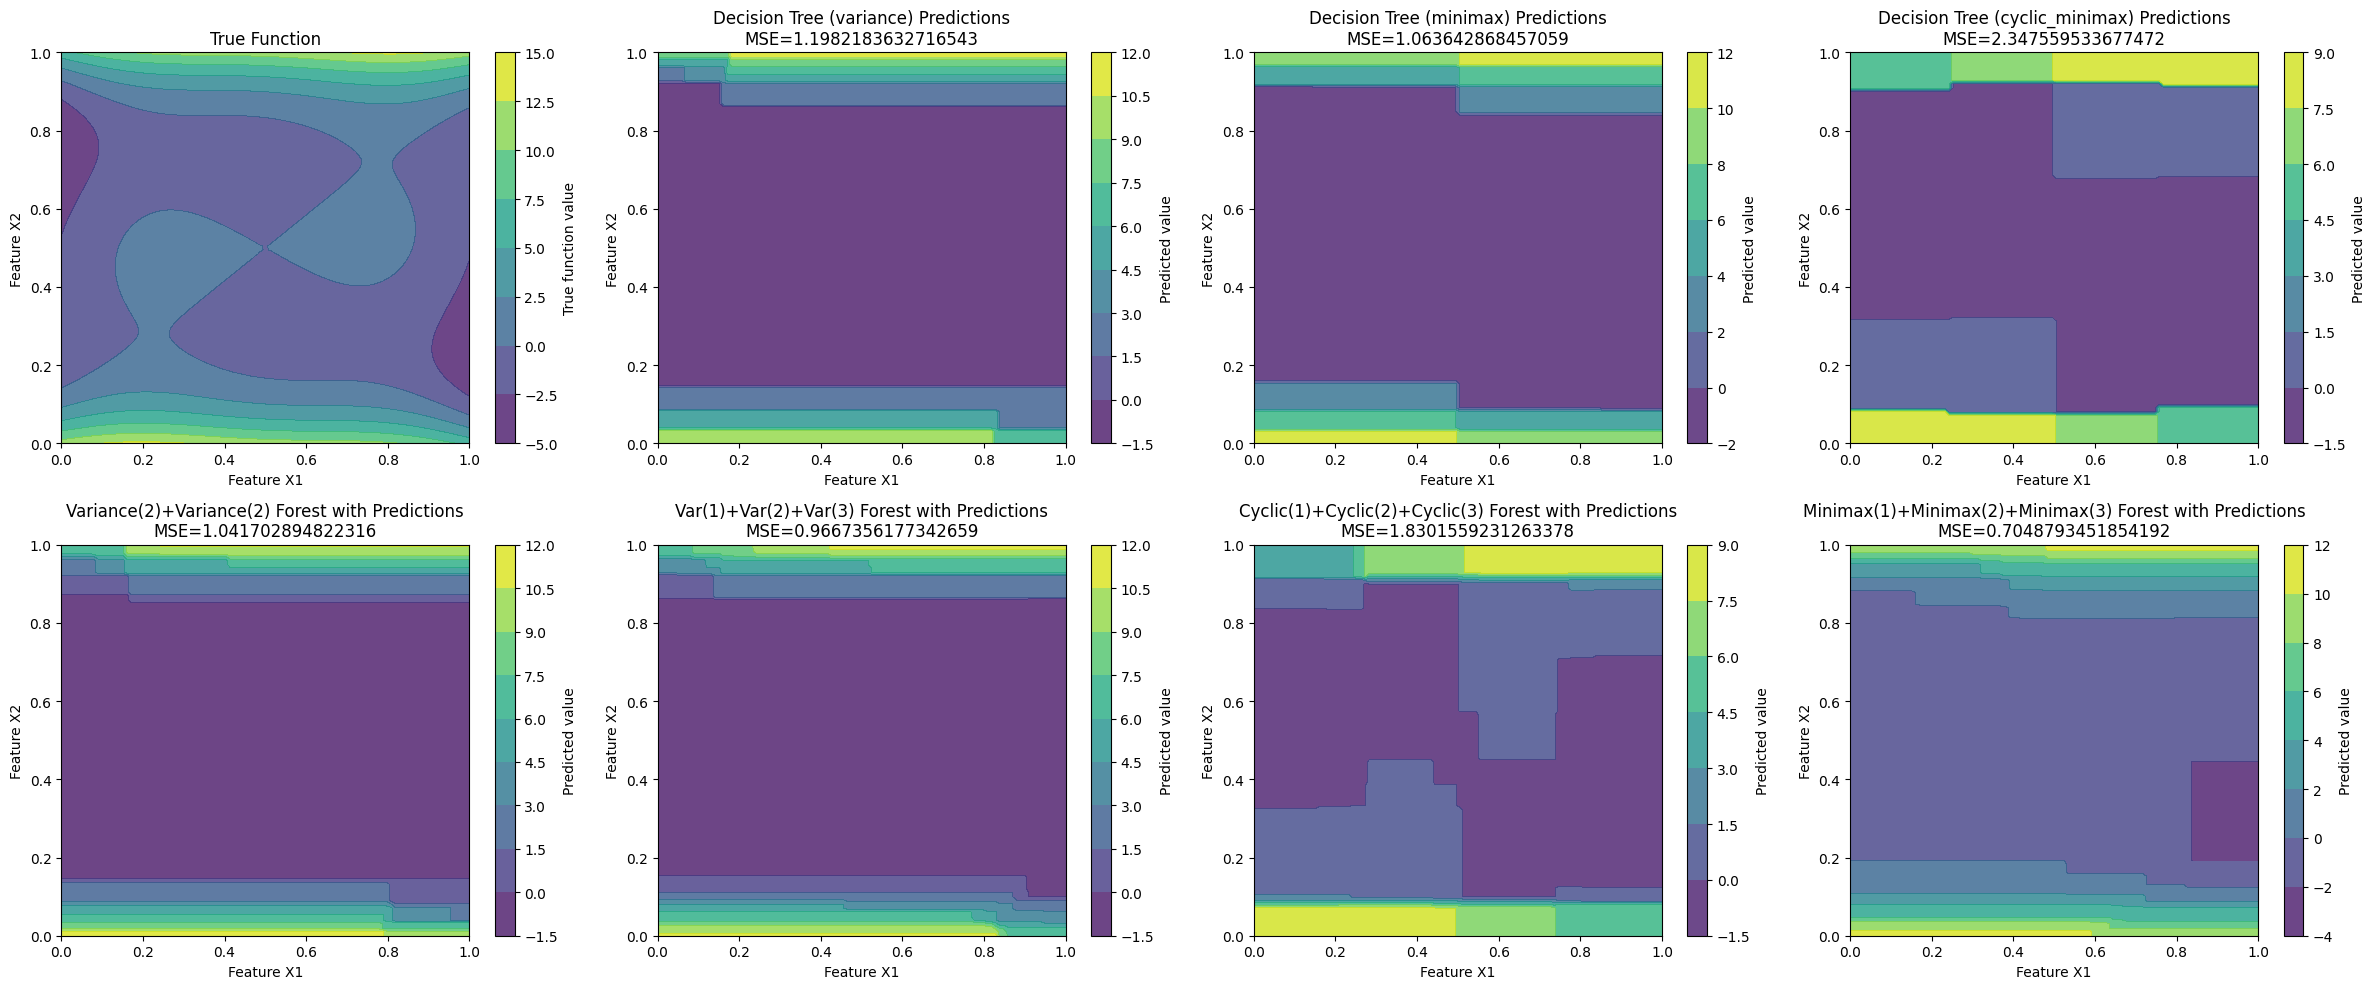

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Setting seed for reproducibility
np.random.seed(1)

# Generating a 2D grid of features
x1 = np.linspace(0, 1, 100)
x2 = np.linspace(0, 1, 100)
X1, X2 = np.meshgrid(x1, x2)
X = np.c_[X1.ravel(), X2.ravel()]  # Create a 2-column matrix of features

# Define a function that depends on X1 and X2
def f_truth(X, noise_var=0.1):
    x1 = (X[:,0] -.5)*3
    x2 = (X[:,1] -.5)*3
    return (2-2.1*x1**2+x1**4/3)*x1**2+x1*x2+(-4+4*x2**2)*x2**2#https://www.sfu.ca/~ssurjano/camel6.html
    #return np.power(X[:, 0], 0.234) + np.sin(2 * np.pi * X[:, 1]) + np.random.randn(X.shape[0]) * noise_var

y = f_truth(X)

# Prepare the mesh grid for predictions and visualization
X_new = np.c_[X1.ravel(), X2.ravel()]
y_new = f_truth(X_new)  # Slightly less noise for cleaner function visualization

shared_max_depth = 4
# Assuming the DecisionTreeRegressor and RandomForestRegressor classes have already been imported and are available
# Variance-based Decision Tree
tree_variance = DecisionTreeRegressor(min_samples_split=4, max_depth=shared_max_depth, error_method='variance', loss_norm=2)
tree_variance.root = tree_variance.fit(X, y)
predictions_variance = tree_variance.predict(X_new)
predictions_variance = np.asarray(predictions_variance).reshape(X1.shape)  # Reshape to 2D grid

# Minimax Decision Tree
tree_minimax = DecisionTreeRegressor(min_samples_split=4, max_depth=shared_max_depth, error_method='minimax', loss_norm=2)
tree_minimax.root = tree_minimax.fit(X, y)
predictions_minimax = tree_minimax.predict(X_new)
predictions_minimax = np.asarray(predictions_minimax).reshape(X1.shape)  # Reshape to 2D grid

# Cyclic minimax Decision Tree
tree_cyclic_minimax = DecisionTreeRegressor(min_samples_split=4, max_depth=shared_max_depth, error_method='cyclic_minimax', loss_norm=2)
tree_cyclic_minimax.root = tree_cyclic_minimax.fit(X, y)
predictions_cyclic_minimax = tree_cyclic_minimax.predict(X_new)
predictions_cyclic_minimax = np.asarray(predictions_cyclic_minimax).reshape(X1.shape)  # Reshape to 2D grid

# Random Forest Regressor
forest = RandomForestRegressor(n_estimators=2, min_samples_split=4, max_depth=shared_max_depth, error_method=['variance','variance'], loss_norm=[2,2])
forest.fit(X, y)
predictions_forest1 = forest.predict(X_new)
predictions_forest1 = np.asarray(predictions_forest1).reshape(X1.shape)  # Reshape to 2D grid

forest = RandomForestRegressor(n_estimators=3, min_samples_split=4, max_depth=shared_max_depth, error_method=['variance','variance','variance'], loss_norm=[1,2,3])
forest.fit(X, y)
predictions_forest2 = forest.predict(X_new)
predictions_forest2 = np.asarray(predictions_forest2).reshape(X1.shape)  # Reshape to 2D grid

forest = RandomForestRegressor(n_estimators=3, min_samples_split=4, max_depth=shared_max_depth, error_method=['cyclic_minimax','cyclic_minimax','cyclic_minimax'], loss_norm=[1,2,3])
forest.fit(X, y)
predictions_forest3 = forest.predict(X_new)
predictions_forest3 = np.asarray(predictions_forest3).reshape(X1.shape)  # Reshape to 2D grid

forest = RandomForestRegressor(n_estimators=3, min_samples_split=4, max_depth=shared_max_depth, error_method=['minimax','minimax','minimax'], loss_norm=[1,2,3])
forest.fit(X, y)
predictions_forest4 = forest.predict(X_new)
predictions_forest4 = np.asarray(predictions_forest4).reshape(X1.shape)  # Reshape to 2D grid



# Plotting the original data and the decision tree approximation
plt.figure(figsize=(24, 10))

# Original function plot
plt.subplot(2, 4, 1)
plt.contourf(X1, X2, y_new.reshape(X1.shape), cmap='viridis', alpha=0.8)
plt.colorbar(label='True function value')
plt.title('True Function')
plt.xlabel('Feature X1')
plt.ylabel('Feature X2')

# Decision tree (variance) predictions plot
plt.subplot(2, 4, 2)
plt.contourf(X1, X2, predictions_variance, cmap='viridis', alpha=0.8)
plt.colorbar(label='Predicted value')
plt.title('Decision Tree (variance) Predictions\nMSE='+str(np.mean((predictions_variance.ravel()-y_new)**2)))
plt.xlabel('Feature X1')
plt.ylabel('Feature X2')

# Decision tree (minimax) predictions plot
plt.subplot(2, 4, 3)
plt.contourf(X1, X2, predictions_minimax, cmap='viridis', alpha=0.8)
plt.colorbar(label='Predicted value')
plt.title('Decision Tree (minimax) Predictions\nMSE='+str(np.mean((predictions_minimax.ravel()-y_new)**2)))
plt.xlabel('Feature X1')
plt.ylabel('Feature X2')

# Decision tree (cyclic_minimax) predictions plot
plt.subplot(2, 4, 4)
plt.contourf(X1, X2, predictions_cyclic_minimax, cmap='viridis', alpha=0.8)
plt.colorbar(label='Predicted value')
plt.title('Decision Tree (cyclic_minimax) Predictions\nMSE='+str(np.mean((predictions_cyclic_minimax.ravel()-y_new)**2)))
plt.xlabel('Feature X1')
plt.ylabel('Feature X2')

# Random Forest predictions plot
plt.subplot(2, 4, 5)
plt.contourf(X1, X2, predictions_forest1, cmap='viridis', alpha=0.8)
plt.colorbar(label='Predicted value')
plt.title('Variance(2)+Variance(2) Forest with Predictions\nMSE='+str(np.mean((predictions_forest1.ravel()-y_new)**2)))
plt.xlabel('Feature X1')
plt.ylabel('Feature X2')

plt.subplot(2, 4, 6)
plt.contourf(X1, X2, predictions_forest2, cmap='viridis', alpha=0.8)
plt.colorbar(label='Predicted value')
plt.title('Var(1)+Var(2)+Var(3) Forest with Predictions\nMSE='+str(np.mean((predictions_forest2.ravel()-y_new)**2)))
plt.xlabel('Feature X1')
plt.ylabel('Feature X2')

plt.subplot(2, 4, 7)
plt.contourf(X1, X2, predictions_forest3, cmap='viridis', alpha=0.8)
plt.colorbar(label='Predicted value')
plt.title('Cyclic(1)+Cyclic(2)+Cyclic(3) Forest with Predictions\nMSE='+str(np.mean((predictions_forest3.ravel()-y_new)**2)))
plt.xlabel('Feature X1')
plt.ylabel('Feature X2')

plt.subplot(2, 4, 8)
plt.contourf(X1, X2, predictions_forest4, cmap='viridis', alpha=0.8)
plt.colorbar(label='Predicted value')
plt.title('Minimax(1)+Minimax(2)+Minimax(3) Forest with Predictions\nMSE='+str(np.mean((predictions_forest4.ravel()-y_new)**2)))
plt.xlabel('Feature X1')
plt.ylabel('Feature X2')

plt.tight_layout()
plt.show()
